In [1]:
%matplotlib inline
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns; sns.set()
from copy import deepcopy
import catboost as cgb
import imp
from bayes_opt import BayesianOptimization
from sklearn.datasets import load_boston
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import r2_score , mean_squared_error
import lightgbm
from scipy.interpolate import interp1d
url="C:/Users/louis/Downloads/Projet/"

In [2]:
def _haversine_distance(lat_A, lon_A, lat_B, lon_B):
    earth_radius = 6373
    distance = np.sin((lat_B - lat_A) / 2) ** 2 + np.cos(lat_A) * \
               np.cos(lat_B) * np.sin((lon_B - lon_A) / 2) ** 2
    distance = 2 * earth_radius * np.arcsin(distance)
    return distance



problem = imp.load_source('', 'problem.py')
X_df, y_array = problem.get_train_data()
X_encoded = X_df

url="C:/Users/louis/Downloads/Projet/"
final = pd.read_csv(url+"Ajout_données.csv")
final["Date"]=pd.to_datetime(final["Date"])

X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
X_encoded['week'] = X_encoded['DateOfDeparture'].dt.week
X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date: (date -pd.to_datetime("1970-01-01")).days)
X_df_Depart = X_encoded.drop("Arrival", axis=1)
X_df_Arrivee = X_encoded.drop("Departure", axis=1)


fusion_depart = X_df_Depart.merge(final.add_suffix('_depart'),how="left", \
left_on=["DateOfDeparture","Departure"],right_on=["Date_depart","AirPort_depart"])
fusion_arrivee = X_df_Arrivee.merge(final.add_suffix('_arrivee'),how="left",\
left_on=["DateOfDeparture","Arrival"],right_on=["Date_arrivee","AirPort_arrivee"])
fusion_arrivee=fusion_arrivee.drop(["DateOfDeparture","WeeksToDeparture",\
                                                          "std_wtd","year","month","day","weekday","week","n_days"],axis=1)
perfect = fusion_depart.merge(fusion_arrivee, left_index=True, right_index=True)

perfect["Precipitationmm_arrivee"]=np.where(perfect["Precipitationmm_arrivee"] == 'T',0,perfect["Precipitationmm_arrivee"])
perfect["Events_arrivee"]=perfect["Events_arrivee"].fillna("Sunny")
perfect["Precipitationmm_depart"]=np.where(perfect["Precipitationmm_depart"] == 'T',0,perfect["Precipitationmm_depart"])
perfect["Events_depart"]=perfect["Events_depart"].fillna("Sunny")
liste_flo = ["lat_arrivee","lon_arrivee","Precipitationmm_arrivee","lat_depart","lon_depart","Precipitationmm_depart"]
perfect[liste_flo]=perfect[liste_flo].astype(float)
perfect['distance'] = _haversine_distance(\
              perfect['lat_arrivee'].values,\
              perfect['lon_arrivee'].values,\
              perfect['lat_depart'].values,\
              perfect['lon_depart'].values)
del perfect["DateOfDeparture"]
perfect=perfect.drop(["DateOfDeparture_arrivee","Date_depart",\
          "DateOfDeparture_depart","Date_arrivee","City_arrivee",\
          "State_arrivee","City_depart","State_depart","AirPort_arrivee",\
          "AirPort_depart","is_weekend_depart","is_holiday_depart",\
          "is_close_from_weekend_or_holiday_depart"],axis=1)
perfect = perfect.rename(columns={'is_weekend_arrivee': 'is_weekend',\
          'is_holiday_arrivee':'is_holiday',\
          'is_close_from_weekend_or_holiday_arrivee':'is_close_from_weekend_or_holiday'})
for i in [c for c, d in zip (perfect.columns,perfect.dtypes) if d==np.bool] :
            perfect[i]=np.where(perfect[i] == False,0,1)   

In [3]:
perfect

,Departure,WeeksToDeparture,std_wtd,year,month,day,weekday,week,n_days,Max TemperatureC_depart,Mean TemperatureC_depart,Min TemperatureC_depart,Dew PointC_depart,MeanDew PointC_depart,Min DewpointC_depart,Max Humidity_depart,Mean Humidity_depart,Min Humidity_depart,Max Sea Level PressurehPa_depart,Mean Sea Level PressurehPa_depart,Min Sea Level PressurehPa_depart,Max VisibilityKm_depart,Mean VisibilityKm_depart,Min VisibilitykM_depart,Max Wind SpeedKm/h_depart,Mean Wind SpeedKm/h_depart,Max Gust SpeedKm/h_depart,Precipitationmm_depart,CloudCover_depart,Events_depart,WindDirDegrees_depart,Unemployment_Rate_depart,Peer_capita_income_depart,Median_income_depart,Average Wage_depart,Net_domestic_migration_rate_per_1000_hab_depart,TFR 2018_depart,lat_depart,lon_depart,elevation_depart,city_population_depart,Arrival,Max TemperatureC_arrivee,Mean TemperatureC_arrivee,Min TemperatureC_arrivee,Dew PointC_arrivee,MeanDew PointC_arrivee,Min DewpointC_arrivee,Max Humidity_arrivee,Mean Humidity_arrivee,Min Humidity_arrivee,Max Sea Level PressurehPa_arrivee,Mean Sea Level PressurehPa_arrivee,Min Sea Level PressurehPa_arrivee,Max VisibilityKm_arrivee,Mean VisibilityKm_arrivee,Min VisibilitykM_arrivee,Max Wind SpeedKm/h_arrivee,Mean Wind SpeedKm/h_arrivee,Max Gust SpeedKm/h_arrivee,Precipitationmm_arrivee,CloudCover_arrivee,Events_arrivee,WindDirDegrees_arrivee,is_weekend,is_holiday,is_close_from_weekend_or_holiday,Unemployment_Rate_arrivee,Peer_capita_income_arrivee,Median_income_arrivee,Average Wage_arrivee,Net_domestic_migration_rate_per_1000_hab_arrivee,TFR 2018_arrivee,lat_arrivee,lon_arrivee,elevation_arrivee,city_population_arrivee,distance
0,ORD,12.875000,9.812647,2012,6,19,1,25,15510,35,31,26,20,18,17,62,51,39,1014,1012,1009,16,16,16,37,25,56.0,0.00,1,Sunny,208,4.3,30417,57444,93013,-8.96,1.73,41.978600,-87.904800,672,2705994,DFW,34,29,24,22,21,19,82,63,44,1012,1010,1009,16,16,16,48,29,60.0,0.00,5,Sunny,161,0,0,0,3.9,27125,53035,88022,2.88,1.92,32.896801,-97.038002,607,1345047,15364.720549
1,LAS,14.285714,9.466734,2012,9,10,0,37,15593,36,32,27,16,13,10,51,36,21,1011,1009,1005,16,15,11,32,18,50.0,0.00,5,Sunny,187,4.6,58646,5145,114480,15.69,1.77,36.080101,-115.152000,2181,644644,DEN,33,25,16,-2,-6,-8,21,14,7,1011,1008,1005,16,16,16,35,15,42.0,0.00,3,Sunny,207,0,0,1,3.3,71953,61303,92261,7.60,1.63,39.861698,-104.672997,5431,716492,14925.196061
2,DEN,10.863636,9.035883,2012,10,5,4,40,15618,6,2,-1,0,-2,-4,92,76,60,1027,1023,1020,16,9,1,27,15,32.0,0.00,7,Rain-Snow,357,3.3,71953,61303,92261,7.60,1.63,39.861698,-104.672997,5431,716492,LAX,22,19,16,17,16,14,93,77,61,1018,1016,1014,16,13,8,24,8,29.0,0.00,5,Fog,266,0,0,1,4.2,75277,61933,111212,-3.95,1.69,33.942501,-118.407997,125,3990456,2195.541841
3,ATL,11.480000,7.990202,2011,10,9,6,40,15256,22,19,16,12,10,6,67,56,44,1026,1024,1021,16,16,16,37,26,45.0,0.00,8,Sunny,70,3.9,58756,49321,56350,3.98,1.79,33.636700,-84.428101,1026,498044,ORD,27,19,11,12,10,9,83,58,33,1028,1026,1024,16,16,16,23,6,29.0,0.00,1,Sunny,93,1,0,0,4.3,30417,57444,93013,-8.96,1.73,41.978600,-87.904800,672,2705994,17546.263732
4,DEN,11.450000,9.517159,2012,2,21,1,8,15391,8,2,-4,-6,-9,-13,46,39,31,1012,1008,1004,16,16,16,61,30,77.0,0.00,5,Sunny,270,3.3,71953,61303,92261,7.60,1.63,39.861698,-104.672997,5431,716492,SFO,16,12,8,10,8,7,93,79,64,1027,1025,1024,16,12,3,24,8,29.0,0.00,7,Sunny,300,0,0,1,4.2,75277,61933,111212,-3.95,1.69,37.618999,-122.375000,13,883305,8975.343420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8897,DTW,9.263158,7.316967,2011,10,2,6,39,15249,17,11,4,6,2,-2,85,56,27,1021,1020,1017,16,16,16,35,19,50.0,0.00,4,Rain,327,4.1,56697,49847,97362,-1.68,1.76,42.212399,-83.353401,645,672662,ATL,20,14,8,4,2,-2,76,51,26,1020,1019,1018,16,16,16,32,16,39.

##### Data Viz 

(array([ 509.,  640., 3760., 2076., 1129.,  788.]),
 array([1.51      , 1.57833333, 1.64666667, 1.715     , 1.78333333,
        1.85166667, 1.92      ]),
 <a list of 6 Patch objects>)

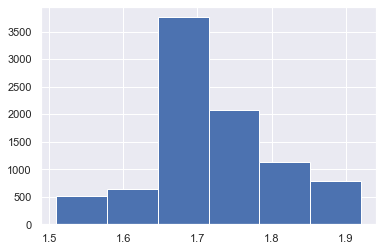

In [4]:
plt.hist(perfect["TFR 2018_depart"],bins=6)

(array([ 578.,  615., 3795., 2078., 1137.,  699.]),
 array([1.51      , 1.57833333, 1.64666667, 1.715     , 1.78333333,
        1.85166667, 1.92      ]),
 <a list of 6 Patch objects>)

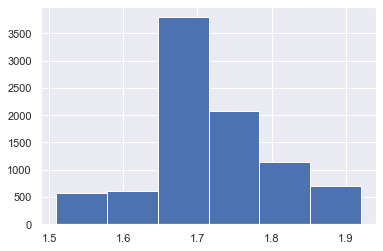

In [5]:
plt.hist(perfect["TFR 2018_arrivee"],bins=6)

In [6]:
perfect["log_PAX"]=y_array

Text(0.5, 1.0, "Répartition de la fréquentation de l'aéroport par le taux de migration de l'Etat de départ")

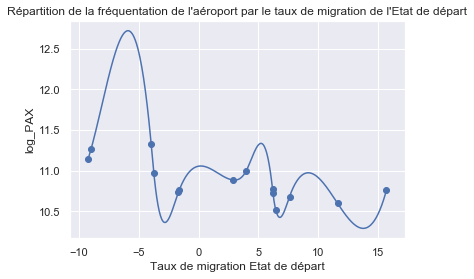

In [7]:
a = pd.DataFrame(perfect.groupby("Net_domestic_migration_rate_per_1000_hab_depart")["log_PAX"].mean().reset_index())

x=np.array(a["Net_domestic_migration_rate_per_1000_hab_depart"])
y=np.array(a["log_PAX"])

x_new = np.linspace(x.min(), x.max(),500)

f = interp1d(x, y, kind='cubic')
y_smooth=f(x_new)

plt.plot (x_new,y_smooth)
plt.scatter (x, y)
plt.xlabel("Taux de migration Etat de départ")
plt.ylabel("log_PAX")
plt.title("Répartition de la fréquentation de l'aéroport par le taux de migration de l'Etat de départ")

Text(0.5, 1.0, "Répartition de la fréquentation de l'aéroport par le salaire médian de l'Etat d'arrivée")

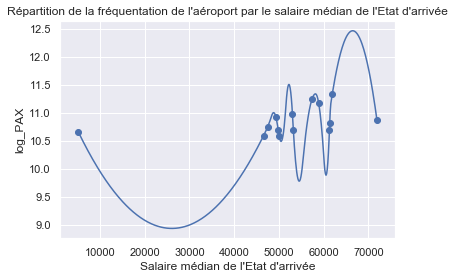

In [8]:
b = pd.DataFrame(perfect.groupby("Median_income_arrivee")["log_PAX"].mean().reset_index())

x=np.array(b["Median_income_arrivee"])
y=np.array(b["log_PAX"])

x_new = np.linspace(x.min(), x.max(),500)

f = interp1d(x, y, kind='quadratic')
y_smooth=f(x_new)

plt.plot (x_new,y_smooth)
plt.scatter (x, y)
plt.xlabel("Salaire médian de l'Etat d'arrivée")
plt.ylabel("log_PAX")
plt.title("Répartition de la fréquentation de l'aéroport par le salaire médian de l'Etat d'arrivée")

Text(0.5, 1.0, "Répartition de la fréquentation de l'aéroport par le taux de chômage de l'Etat de départ")

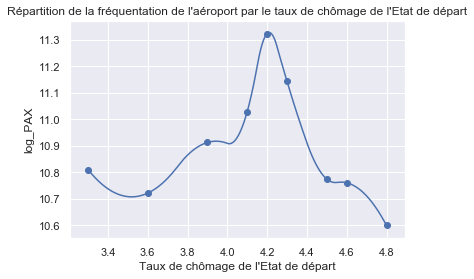

In [9]:
c = pd.DataFrame(perfect.groupby("Unemployment_Rate_depart")["log_PAX"].mean().reset_index())

x=np.array(c["Unemployment_Rate_depart"])
y=np.array(c["log_PAX"])

x_new = np.linspace(x.min(), x.max(),500)

f = interp1d(x, y, kind='quadratic')
y_smooth=f(x_new)

plt.plot (x_new,y_smooth)
plt.scatter (x, y)
plt.xlabel("Taux de chômage de l'Etat de départ")
plt.ylabel("log_PAX")
plt.title("Répartition de la fréquentation de l'aéroport par le taux de chômage de l'Etat de départ")